# Neural Networks vs SVM - Homework

__Métodos Intensivos de Computación Estadística__

Juan Sebastián Corredor Rodriguez - jucorredorr@unal.edu.co

See my [Github Account](https://github.com/juanse1608) to know more about me and my projects.

In [281]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import scipy as sc
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn import datasets,svm,metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_digits
from sklearn import preprocessing
import matplotlib.pylab as plt

## ETL for Digits Dataset

In [436]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
print('The shape of train images is ' + np.str(train_images.shape))
print('The shape of test images is ' + np.str(test_images.shape))

The shape of train images is (60000, 28, 28)
The shape of test images is (10000, 28, 28)


In [437]:
#Normalizing pixels
train_images, test_images = train_images/255.0, test_images/255.0

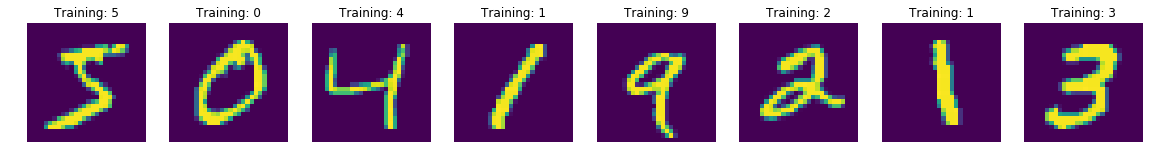

In [438]:
#Let's visualizate the digits (the first n digits)
n = 8
plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.axis('off')
    plt.imshow(train_images[i,:].reshape((28,28)))
    plt.title('Training: %i' % train_labels[i]) 

In this article https://www.pyimagesearch.com/2018/10/08/keras-vs-tensorflow-which-one-is-better-and-which-one-should-i-learn/, It is explained that the best way to proceed is to use Keras with Tensorflow. So, I'll be using Keras inside Tensorflow.

In [440]:
size_labels = len(np.unique(train_labels)) ; size_labels

10

## Neural Networks

Let's see the perfomance of the Networks by changing the number of layers, neurons in each layer, activation functions, epochs and batch size.

The main idea is to pick a model that classifies well the digits in the test dataset without overfitting.

In [441]:
#Se da la estructura del modelo 
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(25, activation=tf.nn.relu),
    keras.layers.Dense(40, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(size_labels, activation=tf.nn.softmax)])

In [442]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=10)

Epoch 1/5
60000/60000 [==============================] - 32s 531us/sample - loss: 0.3478 - acc: 0.8912
Epoch 2/5
60000/60000 [==============================] - 30s 507us/sample - loss: 0.1750 - acc: 0.9471
Epoch 3/5
21970/60000 [=========>....................] - ETA: 19s - loss: 0.1419 - acc: 0.9564

In [226]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

540/540 [==============================] - 0s 93us/sample - loss: 0.1932 - acc: 0.9556
Test accuracy: 0.95555556


After repeting this procedure with several combinations of layers, neurons, epochs and batch sizes, I picked a model with:

1. Train Accuracy: 95.78%
2. Test Accuracy: 95.55%

I think that there is no so much difference between train and test accuracy, so it's not an overfitting model. Let's take a look at the __Confusion Matrix__. 

In [236]:
predictions = model.predict(digits_test)
predictions.shape

(540, 10)

In [237]:
predictions_reshaped = np.apply_along_axis(np.argmax, axis=1, arr=predictions)
predictions_reshaped.shape

(540,)

In [274]:
#Function which objective is to plot in a fancy way the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    fig, ax = plt.subplots(figsize = (10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

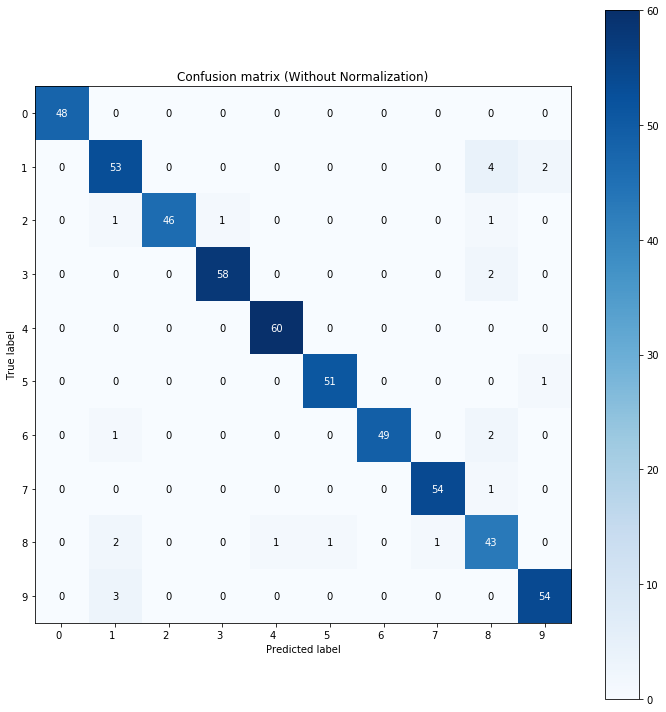

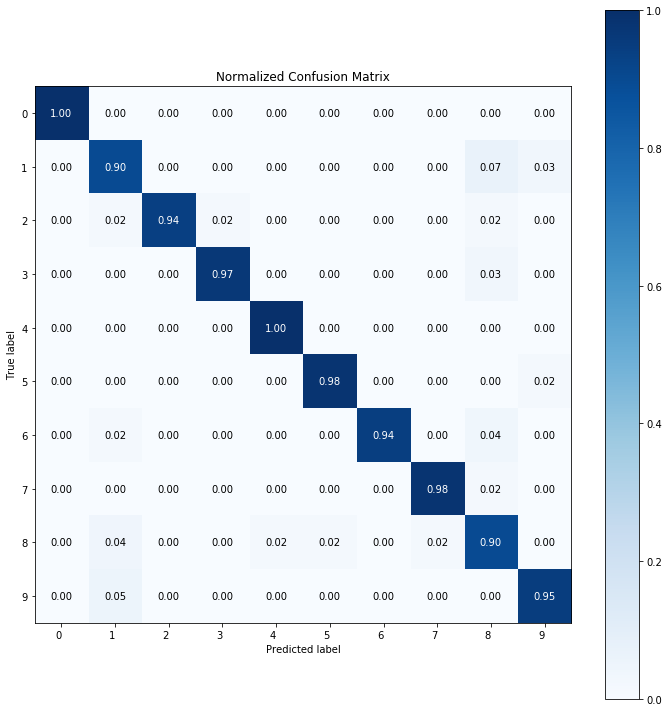

In [275]:
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plot_confusion_matrix(labels_test, predictions_reshaped, classes=np.sort(np.unique(digits.target)),
                      title='Confusion matrix (Without Normalization)')

plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(labels_test, predictions_reshaped, classes=np.sort(np.unique(digits.target)),
                      normalize=True, title='Normalized Confusion Matrix')

plt.show()

Note that 1 and 8 are the labels with lowest, but still very high, accuracy (with 90%). On the other hand, 0 and 4 are being predicted perfectly.

### Convolutional Neural Networks 

Let's see if we can get better using convolutional neural networks. This type of networks learns by looking what happens in little windows of the image. 

In [289]:
len(digits_train) 

1257

In [363]:
train_images_conv = train_images.reshape((len(train_images), 28, 28, 1))
test_images_conv = test_images.reshape((len(test_images), 28, 28, 1))

In [403]:
model = models.Sequential()
model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu'))

In [404]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [405]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, labels_train, epochs=5, batch_size=5)

Epoch 1/5
1257/1257 [==============================] - 2s 2ms/sample - loss: 1.2064 - acc: 0.6356
Epoch 2/5
1257/1257 [==============================] - 1s 1ms/sample - loss: 0.3287 - acc: 0.9014
Epoch 3/5
1257/1257 [==============================] - 1s 1ms/sample - loss: 0.1976 - acc: 0.9403
Epoch 4/5
1257/1257 [==============================] - 1s 1ms/sample - loss: 0.1387 - acc: 0.9618
Epoch 5/5
1257/1257 [==============================] - 1s 1ms/sample - loss: 0.0889 - acc: 0.9777


In [406]:
test_loss, test_acc = model.evaluate(test_images, labels_test)

print('Test accuracy:', test_acc)

540/540 [==============================] - 1s 2ms/sample - loss: 0.1348 - acc: 0.9537
Test accuracy: 0.9537037


In [407]:
#Cargamos la funci´on input_data con el fin de extraer el conjunto de datos:
from tensorflow.examples.tutorials.mnist import input_data
#Cargamos los sets de imagenes en el objeto mnist:
mnist=input_data.read_data_sets("MNIST_data", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [411]:
mnist.train.

array(<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1a58ed4588>,
      dtype=object)